## Data Description and Sources

### Total return
full name: Hang Seng Gross Total Return Index 

Innercode: 1151235 (Secucode: HSITR)

requirements: monthly prices

source: jydb

### Implied Vol

requirements: at-the-money implied vol of maturities ranging from 30days to 365 days (end-of-month dates only)

source: live data from REUTERS, historical data downloaded

can see some historical data using **0#HSIVOLSURF**

IV different for put and call using **HSIATMIV.HF**

for each option: data field (Strike, CF_Last

### Risk free rate
full name: Hong Kong Interbank Offered Rate (HIBOR) 

requirements: monthly

source: **HIHKD1YD=** from REUTERS

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import norm
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
import seaborn as sns
from strat import getData

In [2]:
## read in volatility - from Eikon
# data = pd.read_excel("data.xlsx", sheet_name="impvol-cleaned", index_col=0)
# eodata = data[data.eomonth].iloc[:,:8]
# eodata = eodata.stack().reset_index()
# eodata.columns = ["date", "maturity", "vol"]
# eodata['T'] = eodata["maturity"].str.strip("M").astype(int)/12
# eodata['d'] = eodata['vol']/100/2*np.sqrt(eodata['T'])
# list(map(lambda x: (norm.cdf(x)-norm.cdf(-x))/()), eodata['d'])

<AxesSubplot:>

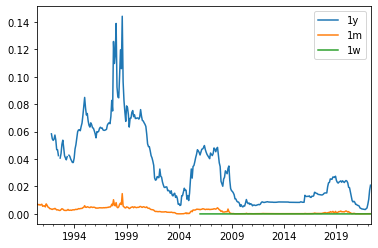

In [3]:
# read in risk free rate - only month-end, date adjustement
data_rf1m = pd.read_excel("data.xlsx", sheet_name="hibor1m-raw", index_col=0, skiprows=1)
data_rf1m['Close'] = (data_rf1m['Close']/100+1)**(1/12)-1 # change to monthly scale
data_rf1y = pd.read_excel("data.xlsx", sheet_name="hibor1y-raw", index_col=0, skiprows=1)
data_rf1y['Close'] = data_rf1y['Close']/100
data_rf1w = pd.read_excel("data.xlsx", sheet_name="hibor1w-raw", index_col=0, skiprows=1)
data_rf1w['Close'] = (data_rf1y['Close']/100+1)**(1/52)-1
rf_all = pd.concat([data_rf1y, data_rf1m, data_rf1w], axis = 1)
rf_all.columns = ['1y', '1m', '1w']
rf_all.index = pd.to_datetime(rf_all.index)
rf = rf_all.sort_index(ascending=False)
rf = rf[rf.groupby([rf.index.year,rf.index.month]).cumcount()==0].sort_index()
rf.index = list(map(lambda x: x + MonthEnd(0), rf.index))
rf
rf.plot()

In [4]:
# read in total return series - 1m and 1y forward return, date adjustment
import mysql.connector
config = {
        'user': 'infoport',
        'password': 'HKaift-123',
        'host': '192.168.2.81',
        'database': 'AlternativeData',
        'raise_on_warnings': False
    }
def connectDB(config):
    try:
        cnx = mysql.connector.connect(**config)
        return cnx
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
        return 0
cnx = connectDB(config)
query = "SELECT TradingDay as date, ClosePrice as price FROM jydb.QT_OSIndexQuote where indexcode = 1151235;"
data = pd.read_sql(query, cnx)
data["date"] = pd.to_datetime(data["date"])
data['helper'] = data.groupby([data.date.dt.year, data.date.dt.month]).date.rank(ascending=False)
data['eomonth'] = np.where(data.helper==1, True, False)
data['eoweek'] = np.where(data.date.dt.weekday>data.shift(-1).date.dt.weekday, True, False)
# data['eomonth'] = np.where(data.date.dt.month<data.shift(-1).date.dt.month, True, False)
# data['eoweek'] = np.where(data.date.dt.weekday>data.shift(-1).date.dt.weekday, True, False)
data = data.set_index("date")

In [5]:
# monthly return - forward 1 year and 1 month
vol = data.price.pct_change().groupby([data.index.month, data.index.year]).std().shift(-1)
vol.index = data.groupby([data.index.month, data.index.year]).tail(1).index

hsi = pd.concat([data[data['eomonth']].price.pct_change().shift(-1),
                 data[data['eomonth']].price.pct_change(periods=12).shift(-12),
                vol], axis=1)
hsi.columns = ['ret_1m', 'ret_1y', 'vol_1m']
hsi.index = list(map(lambda x: x + MonthEnd(0), hsi.index))
hsi.head()


,ret_1m,ret_1y,vol_1m
2004-10-31,0.081466,0.142659,0.008085
2004-11-30,0.012885,0.101772,0.012677
2004-12-31,-0.035731,0.084121,0.040929
2005-01-31,0.034702,0.190550,0.026501
2005-02-28,-0.040553,0.162881,0.012290


In [6]:
# read in historical data - from Siyu
data_put = pd.read_excel("Data for HKAIFT.xlsx", sheet_name = "HSI_Put_Option")
data_call =pd.read_excel("Data for HKAIFT.xlsx", sheet_name = "HSI_Call_Option")
data_put = data_put[["Date", "Days", "Maturity", "ImpliedVol", "Strike", "Premium", "HSI"]]
data_put = data_put[data_put["Days"]<=182]
data_call = data_call[["Date", "Days", "Maturity", "ImpliedVol", "Strike", "Premium", "HSI"]]
data_call = data_call[data_call["Days"]<=182]
data_put = data_put.set_index("Date")
data_call = data_call.set_index("Date")

# np.log(1/data_call['HSI'])+data_call['ImpliedVol']**2/2*data_call["Maturity"]
data_call['d1'] = data_call['ImpliedVol']/2*data_call["Maturity"]**0.5
data_call['v'] = data_call.d1.apply(lambda x: norm.cdf(x)-norm.cdf(-x))

data_put['d1'] = data_put['ImpliedVol']/2*data_put["Maturity"]**0.5
data_put['v'] = data_put.d1.apply(lambda x: norm.cdf(x))-data_put.d1.apply(lambda x: norm.cdf(-x))

data_ratio = pd.concat([data_put['v']/data_call['v'] - 1, data_put['Maturity']], axis=1)
# spc = data_ratio.groupby("Date").apply(lambda s: ((s['v']*s['Maturity']).sum() - s['v'].sum()*s['Maturity'].sum())/((s['Maturity']**2).sum()-s['Maturity'].sum()**2))
spc = data_ratio.groupby("Date").apply(lambda s: np.cov(s[['v', 'Maturity']], rowvar=False, bias=True)[1,0]/np.var(s['Maturity']))#*7/8 # adjust for N-1 factor
spc.index = pd.to_datetime(spc.index)
spc.index = list(map(lambda x: x + MonthEnd(0), spc.index))
spc.name = "spc"
# spc.plot(figsize=(15,3))

<AxesSubplot:>

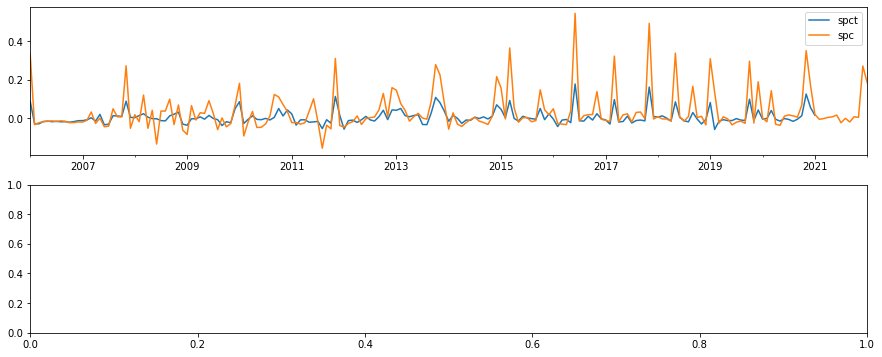

In [7]:
# cross check with Siyu output
ref = pd.read_excel("Data for HKAIFT.xlsx", sheet_name = "RegMod", index_col=0)
# ref = pd.read_excel("Data for HKAIFT.xlsx", sheet_name = "After19", index_col=0)

ref.index = pd.to_datetime(ref.index)
ref.index = list(map(lambda x: x + MonthEnd(0), ref.index))

fig, axes = plt.subplots(figsize=(15,6), nrows=2)
comp = pd.concat([ref.spct, spc], axis=1)
# comp.diff(axis=1)
comp.plot(ax=axes[0])

# comp = pd.concat([ref.ExcessR, df.exr_1y], axis=1)
# # comp.diff(axis=1)
# comp.plot(ax=axes[1])

In [109]:
df = pd.concat([hsi, rf, spc], axis=1).dropna(how="any")
df['exr_1y'] = df['ret_1y'] - df['1y']
df['exr_1m'] = df['ret_1m'] - df['1m']
df['year'] = df.index.year
df['const'] = 1

                            OLS Regression Results                            
Dep. Variable:                 exr_1y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.806
Date:                Fri, 27 May 2022   Prob (F-statistic):              0.181
Time:                        17:30:14   Log-Likelihood:                 69.876
No. Observations:                 139   AIC:                            -135.8
Df Residuals:                     137   BIC:                            -129.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spc           -0.1688      0.126     -1.344      0.1

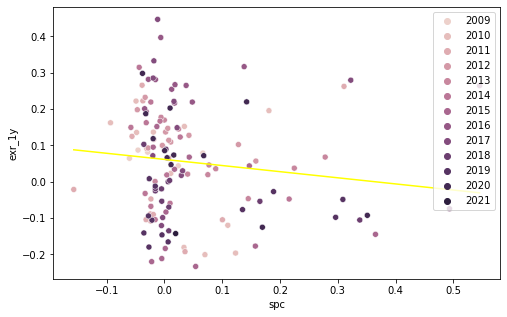

In [113]:
# 1y return - non-crisis
period = (df.index>pd.to_datetime("2009-07-01"))&(df.index<=pd.to_datetime("2021-02-01"))
res = sm.OLS(df.loc[period, "exr_1y"], df.loc[period, ["spc","const"]]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
# df.loc[period].plot.scatter(x="spc", y="exr_1y")

print(res.summary())

plt.figure(figsize=(8,5))
sns.scatterplot(x="spc", y="exr_1y", data=df[period], hue="year",legend="full")

df['line_1y_non'] = df['spc']*res.params['spc'] + res.params['const']
sns.lineplot(data=df, x="spc", y="line_1y_non", color="yellow")

print("r = {:.4f} + {:.4f} * spc (t={:.2f})".format(res.params['const'], res.params['spc'], res.tvalues['spc']))

                            OLS Regression Results                            
Dep. Variable:                 exr_1m   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6491
Date:                Fri, 27 May 2022   Prob (F-statistic):              0.422
Time:                        15:52:52   Log-Likelihood:                 218.02
No. Observations:                 139   AIC:                            -432.0
Df Residuals:                     137   BIC:                            -426.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spc            0.0302      0.038      0.806      0.4

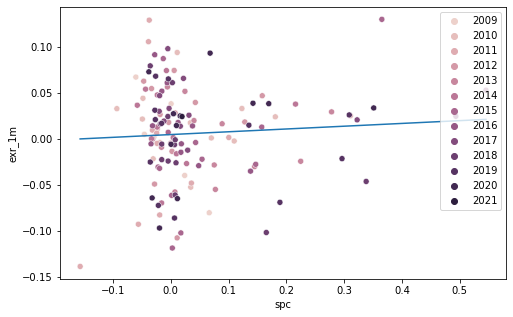

In [10]:
# 1m return - non-crisis
import statsmodels.api as sm
res = sm.OLS(df.loc[period, "exr_1m"], df.loc[period, ["spc","const"]]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
# df.loc[period].plot.scatter(x="spc", y="exr_1m")

print(res.summary())

plt.figure(figsize=(8,5))
sns.scatterplot(x="spc", y="exr_1m", data=df[period], hue="year",legend="full")

df['line_1m_non'] = df['spc']*res.params['spc'] + res.params['const']
sns.lineplot(data=df, x="spc", y="line_1m_non")

print("r = {:.4f} + {:.4f} * spc (t={:.2f})".format(res.params['const'], res.params['spc'], res.tvalues['spc']))
# sns.scatterplot(x="spc", y="exr_1y", data=df, hue="year")
# tried running regression of the ratio over 1-month future return. the coef is significant (t=2 and p-value = 4%). 

                            OLS Regression Results                            
Dep. Variable:                 exr_1m   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.3002
Date:                Fri, 27 May 2022   Prob (F-statistic):              0.585
Time:                        15:52:52   Log-Likelihood:                 217.89
No. Observations:                 139   AIC:                            -431.8
Df Residuals:                     137   BIC:                            -425.9
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spc_1d        -0.0168      0.031     -0.548      0.5

<AxesSubplot:xlabel='spc_1d', ylabel='exr_1m'>

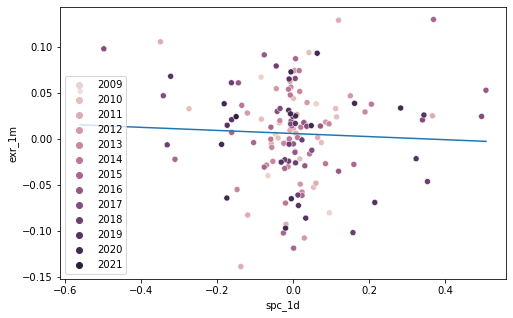

In [11]:
# 1m return with lag - non-crisis
import statsmodels.api as sm
df['spc_1d'] = df["spc"].diff(1)
res = sm.OLS(df.loc[period, "exr_1m"], df.loc[period, ["spc_1d", "const"]]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
# df.loc[period].plot.scatter(x="spc", y="exr_1m")

print(res.summary())

plt.figure(figsize=(8,5))
sns.scatterplot(x="spc_1d", y="exr_1m", data=df[period], hue="year",legend="full")

df['line_1m_non'] = df['spc_1d']*res.params['spc_1d'] + res.params['const']
sns.lineplot(data=df, x="spc_1d", y="line_1m_non")

                            OLS Regression Results                            
Dep. Variable:                 vol_1m   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3907
Date:                Fri, 27 May 2022   Prob (F-statistic):              0.533
Time:                        15:52:53   Log-Likelihood:                 486.47
No. Observations:                 139   AIC:                            -968.9
Df Residuals:                     137   BIC:                            -963.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
spc           -0.0027      0.004     -0.625      0.5

<AxesSubplot:xlabel='spc', ylabel='exr_1m'>

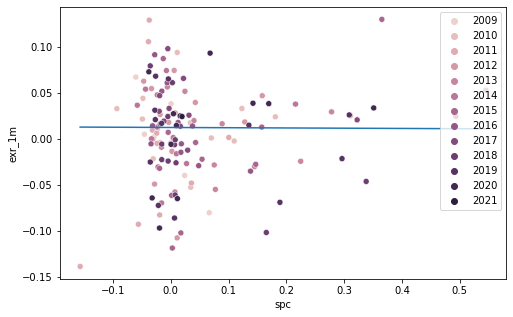

In [12]:
import statsmodels.api as sm

res = sm.OLS(df.loc[period, "vol_1m"], df.loc[period, ["spc", "const"]]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
# df.loc[period].plot.scatter(x="spc", y="exr_1m")

print(res.summary())

plt.figure(figsize=(8,5))
sns.scatterplot(x="spc", y="exr_1m", data=df[period], hue="year",legend="full")

df['line_1m_non'] = df['spc']*res.params['spc'] + res.params['const']
sns.lineplot(data=df, x="spc", y="line_1m_non")

## Weekly data

In [13]:
# read in data on Fridays
data_all = pd.read_csv('data2.csv')
data_all = data_all[['Date', 'Days', 'ImpliedVol', 'CallPut','Delta']]

def process(df):
    df = df.copy()
    df.loc[:,'Maturity'] = df.loc[:,'Days']/365
    df.loc[:,'Date'] = pd.to_datetime(df.loc[:,'Date'])
    week_grouper = df.Date.dt.isocalendar()
    df = df.loc[df.groupby([week_grouper['year'], week_grouper['week'], df['Days']]).Date.rank(ascending=False)==1,:]
    df['Date'] = df.Date.apply(lambda x: x + np.timedelta64(4-x.weekday(), 'D'))
    return df

call = process(data_all.loc[(data_all['Delta']==50)&(data_all['Days']<=182),:])
put = process(data_all.loc[(data_all['Delta']==-50)&(data_all['Days']<=182),:])
call = call.set_index("Date")
put = put.set_index("Date")

In [14]:
call['d1'] = call['ImpliedVol']/2*call["Maturity"]**0.5
call['v'] = call.d1.apply(lambda x: norm.cdf(x)-norm.cdf(-x))

put['d1'] = put['ImpliedVol']/2*put["Maturity"]**0.5
put['v'] = put.d1.apply(lambda x: norm.cdf(x))-put.d1.apply(lambda x: norm.cdf(-x))

ratio = pd.concat([put['v']/call['v'] - 1, put['Maturity']], axis=1)
# spc = data_ratio.groupby("Date").apply(lambda s: ((s['v']*s['Maturity']).sum() - s['v'].sum()*s['Maturity'].sum())/((s['Maturity']**2).sum()-s['Maturity'].sum()**2))
spc_week = ratio.groupby("Date").apply(lambda s: np.cov(s[['v', 'Maturity']], rowvar=False)[1,0]/np.var(s['Maturity']))*7/8 # adjust for N-1 factor
spc_week.name = "spc"

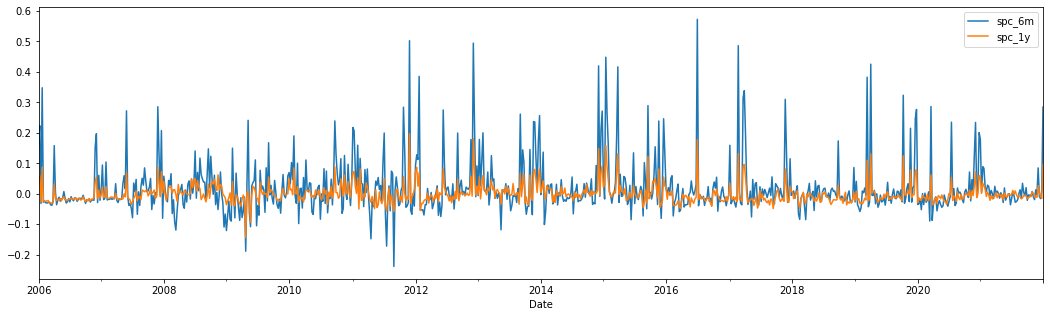

In [100]:
# compare different length
call1 = process(data_all.loc[(data_all['Delta']==50)&(data_all['Days']<=365),:])
put1 = process(data_all.loc[(data_all['Delta']==-50)&(data_all['Days']<=365),:])
call1 = call1.set_index("Date")
put1 = put1.set_index("Date")
call1['d1'] = call1['ImpliedVol']/2*call1["Maturity"]**0.5
call1['v'] = call1.d1.apply(lambda x: norm.cdf(x)-norm.cdf(-x))

put1['d1'] = put1['ImpliedVol']/2*put1["Maturity"]**0.5
put1['v'] = put1.d1.apply(lambda x: norm.cdf(x))-put1.d1.apply(lambda x: norm.cdf(-x))

ratio1 = pd.concat([put1['v']/call1['v'] - 1, put1['Maturity']], axis=1)
# spc = data_ratio.groupby("Date").apply(lambda s: ((s['v']*s['Maturity']).sum() - s['v'].sum()*s['Maturity'].sum())/((s['Maturity']**2).sum()-s['Maturity'].sum()**2))
spc_week1 = ratio1.groupby("Date").apply(lambda s: np.cov(s[['v', 'Maturity']], rowvar=False)[1,0]/np.var(s['Maturity']))*7/8 # adjust for N-1 factor
spc_week1.name = "spc"

spc_comp = pd.concat([spc_week, spc_week1], axis=1)
spc_comp.columns = ['spc_6m', 'spc_1y']
spc_comp.plot(figsize=(18,5))
spc_diff = spc_comp.diff(axis=1).spc_1y
# spc_diff.plot(figsize=(18,5), style='.')
# spc_diff.name = "spc_diff"

In [29]:
# weekly - forward 1 week
hsi_week = pd.concat([data[data['eoweek']].price.pct_change().shift(-1),
                      data[data['eoweek']].price.pct_change(periods=4).shift(-4)],axis=1)
hsi_week.index = pd.Series(list(map(lambda x: x + np.timedelta64(4-x.weekday(), 'D'),hsi_week.index)))
hsi_week.columns = ['ret_1w', 'ret_4w']

In [30]:
# weekly risk-free rate
rf_week = rf_all.groupby([rf_all.index.isocalendar().year, rf_all.index.isocalendar().week]).tail(1)
rf_week.index = pd.Series(list(map(lambda x: x + np.timedelta64(4-x.weekday(), 'D'),rf_week.index)))

                            OLS Regression Results                            
Dep. Variable:                 exr_1w   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3487
Date:                Fri, 27 May 2022   Prob (F-statistic):              0.555
Time:                        17:18:47   Log-Likelihood:                 1491.8
No. Observations:                 679   AIC:                            -2980.
Df Residuals:                     677   BIC:                            -2971.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.654      0.0

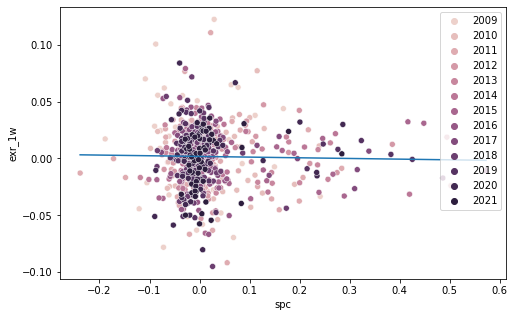

In [98]:
df_week = pd.concat([hsi_week, rf_week, spc_week, spc_diff], axis=1).dropna(how="any")
df_week['exr_1w'] = df_week['ret_1w'] - df_week['1w']
df_week['exr_4w'] = df_week['ret_4w'] - df_week['1m']
df_week['year'] = df_week.index.year
df_week['const'] = 1
period = df_week.index>=pd.to_datetime("2009-01-01")

import statsmodels.api as sm
res = sm.OLS(df_week.loc[period, "exr_1w"], df_week.loc[period, ['const', 'spc']]).fit(cov_type='HAC',cov_kwds={'maxlags':1}, use_t=True)
print(res.summary())
print("")

plt.figure(figsize=(8,5))
sns.scatterplot(x="spc", y="exr_1w", data=df_week[period], hue="year",legend="full")

df_week['line_1w_non'] = df_week['spc']*res.params['spc'] + res.params['const']
sns.lineplot(data=df_week[period], x="spc", y="line_1w_non")
print("r = {:.4f} + {:.4f} * spc (t={:.2f})".format(res.params['const'], res.params['spc'], res.tvalues['spc']))

                            OLS Regression Results                            
Dep. Variable:                 exr_4w   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1109
Date:                Fri, 27 May 2022   Prob (F-statistic):              0.739
Time:                        17:24:21   Log-Likelihood:                 1034.9
No. Observations:                 679   AIC:                            -2066.
Df Residuals:                     677   BIC:                            -2057.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.003      2.425      0.0

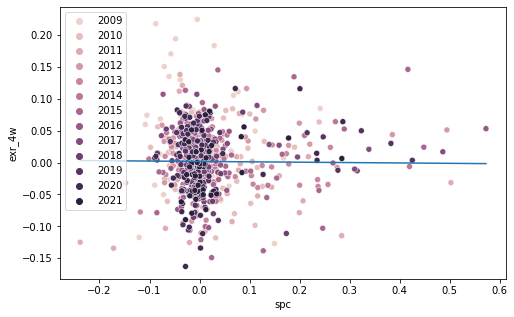

In [104]:
# 4-week forecast
import statsmodels.api as sm
res = sm.OLS(df_week.loc[period, "exr_4w"], df_week.loc[period, ['const', 'spc']]).fit(cov_type='HAC',cov_kwds={'maxlags':1}, use_t=True)
print(res.summary())
print("")

plt.figure(figsize=(8,5))
sns.scatterplot(x="spc", y="exr_4w", data=df_week[period], hue="year",legend="full")

df_week['line_4w_non'] = df_week['spc']*res.params['spc'] + res.params['const']
sns.lineplot(data=df_week[period], x="spc", y="line_1w_non")
print("r = {:.4f} + {:.4f} * spc (t={:.2f})".format(res.params['const'], res.params['spc'], res.tvalues['spc']))

In [ ]:
spc_roll = spc_week.groupby([spc_week.index.year, spc_week.index.isocalendar().week]).mean()
spc_roll.index = spc_week.index
df_roll = pd.concat([hsi_week, rf_week, spc_week], axis=1).dropna(how="any")
df_week['exr_1w'] = df_week['ret_1w'] - df_week['1w']
df_week['exr_4w'] = df_week['ret_4w'] - df_week['1m']
df_week['year'] = df_week.index.year
df_week['const'] = 1
period = df_week.index>=pd.to_datetime("2009-01-01")

import statsmodels.api as sm
res = sm.OLS(df_week.loc[period, "exr_1w"], df_week.loc[period, ['const', 'spc']]).fit(cov_type='HAC',cov_kwds={'maxlags':1}, use_t=True)
print(res.summary())
print("")

plt.figure(figsize=(8,5))
sns.scatterplot(x="spc", y="exr_1w", data=df_week[period], hue="year",legend="full")

df_week['line_1w_non'] = df_week['spc']*res.params['spc'] + res.params['const']
sns.lineplot(data=df_week[period], x="spc", y="line_1w_non")
print("r = {:.4f} + {:.4f} * spc (t={:.2f})".format(res.params['const'], res.params['spc'], res.tvalues['spc']))

## Formula Approximation

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.679e+09
Date:                Fri, 27 May 2022   Prob (F-statistic):                        0.00
Time:                        16:55:01   Log-Likelihood:                          23778.
No. Observations:                3000   AIC:                                 -4.755e+04
Df Residuals:                    2998   BIC:                                 -4.754e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.8026   3.69e-05   2.18e+04      0.000       0.802       0.803
1             -0.0524      0.000   -330.275      0.000      -0.053      -0.052
==============================================================================
Omnibus:                     2470.521   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.953
Skew:                          -0.020   Prob(JB):                     8.39e-40
Kurtosis:                       1.801   Cond. No.                         18.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

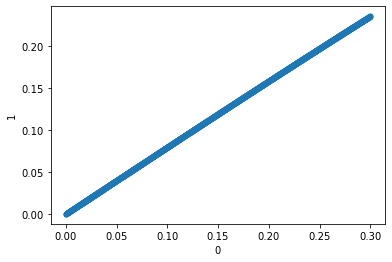

In [95]:
# mathematical 
rng = pd.Series([i/10000 for i in range(0,3000)])
pd.concat([rng, rng.apply(lambda x: norm.cdf(x)-norm.cdf(-x))], axis=1).plot.scatter(x=0, y=1)
d_value = rng.apply(lambda x: norm.cdf(x)-norm.cdf(-x))
import scipy.stats
scipy.stats.linregress(rng, d_value)

model = sm.OLS(d_value, pd.concat([rng, rng**2], axis=1))
model.fit().summary()

<AxesSubplot:xlabel='Date'>

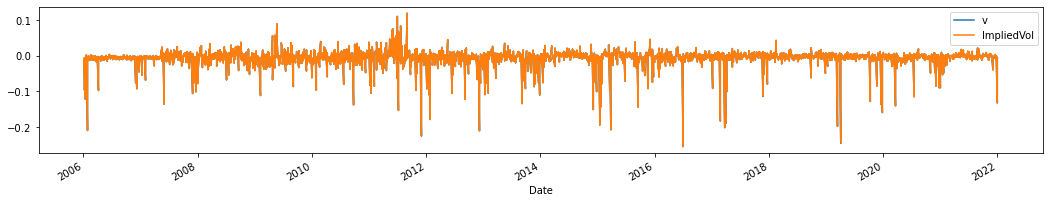

In [90]:
ratio_approx = (0.7872*(put['ImpliedVol'] - call['ImpliedVol'])) / (0.7872*call['ImpliedVol']+0.00063)
# ratio_approx = put['ImpliedVol'] / call['ImpliedVol'] - 1
pd.concat([ratio.v, ratio_approx], axis=1).plot(figsize=(18,3))

<AxesSubplot:xlabel='Date'>

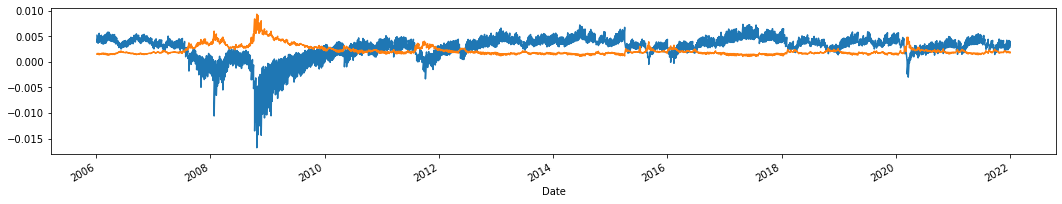

In [93]:
(pd.concat([ratio_approx, ratio.v], axis=1).diff(axis=1).v/ratio.v).plot(figsize=(18,3))
(call['ImpliedVol']/100).plot(figsize=(18,3))

## Back-solving for Implied Vol
[formula reference](http://www.columbia.edu/~mh2078/FoundationsFE/BlackScholes.pdf)

In [165]:
import math
def bs(S, K, T, r, sigma, q, op_type):
    """
    calculate option price using Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r+sigma**2/2)*T)/(sigma*T**(0.5))
    d2 = d1 - sigma*T**(0.5)
    if op_type == "C":
        return norm.cdf(d1)*S*math.exp(-q*T) - norm.cdf(d2)*K*math.exp(-r*T)
    else:
        return norm.cdf(-d2)*K*math.exp(-r*T) - norm.cdf(-d1)*S

In [20]:
bs(S=20605, K = 20000, T = 1/12, r = 0, q = 0, sigma = 0.3, op_type="C")

1044.8042375202403

In [192]:
def iv_bisection(S, K, T, r, q, p, op_type, verbose=False):
    """
    solve for implied volatility using bi-section method
    """
    rng = (0.0001, 1)
    mid = bs(S, K, T, r, (rng[0]+rng[1])/2, q, op_type)
    i = 0
    while abs(p-mid) >= 10**-7:
        if p < mid:
            rng = (rng[0], (rng[0]+rng[1])/2)
        else:
            rng = ((rng[0]+rng[1])/2, rng[1])
        mid = bs(S, K, T, r, (rng[0]+rng[1])/2, q, op_type)
        if verbose:
            print("range is {:.2f} and {:.2f}".format(rng[0], rng[1]))
        i += 1
    return (rng[0]+rng[1])/2, i

In [193]:
import math
def vega(S, K, T, r, sigma, q):
    d1 = (np.log(S/K) + (r-q+sigma**2/2)*T)/(sigma*T**(0.5))
    return math.exp(-q*T)*S*math.sqrt(T)*norm.cdf(d1)

def iv_newton(S, K, T, r, q, p, op_type, verbose=False, max_iter=1000):
    """
    solve for implied volatility using newton's method
    """
    if op_type == "C":
        rng = np.sqrt(2*math.pi/T)*p/S
    else:
        c = S + p - K
        rng = np.sqrt(2*math.pi/T)*c/S
        
    mid = bs(S, K, T, r, rng, q, op_type)
    i = 0
    while abs(p-mid) >= 10**-7 and i < max_iter:
        v = vega(S, K, T, r, rng, q)
        rng = rng - (mid-p)/v
        i += 1
        mid = bs(S, K, T, r, rng, q, op_type)
        if verbose:
            print("solution: {} with vega: {}".format(rng, v))
    return rng, i

In [194]:
iv_bisection(S=20605, K = 20000, T = 1/12, r = 0, q = 0, p = 1044, op_type="C")

(0.29963464457847877, 32)

In [196]:
iv_newton(S=20605, K = 20000, T = 1/12, r = 0, q = 0, p = 1044, op_type="C")

(0.29963464461770023, 26)

## Getting Data
excel formula: `=RDP.HistoricalPricing(B2,"IMP_VOLT","START:"&A2&" END:"&A2&" INTERVAL:P1D SOURCE:RFV",,,D2)`

delta `=RDP.HistoricalPricing(B2,"DELTA","START:"&A2&" END:"&A2&" INTERVAL:P1D SOURCE:RFV",,,F2)`

settle price `=RDP.HistoricalPricing(B2,"SETTLE","START:"&A2&" END:"&A2&" INTERVAL:P1D SOURCE:RFV",,,J2)`

settlement date `=RDP.Data("HSI20000R2.HF","","CH=Fd RH=IN",K7)`

option contract terms and rules: see this [link](https://www.ebshkdirect.com/product/en_US/futures/cs_hsio.html)

In [276]:
hsi = getData("1001098", add_spc=False, start_dt="2022-05-01", end_dt="2022-05-31")
hsi.head()

,close,low,high,open,volume,openinterest
datetime,,,,,,
2022-05-03,21101.89,20648.53,21291.80,20927.62,1.067048e+07,0
2022-05-04,20869.52,20772.80,21047.13,21025.70,7.244771e+06,0
2022-05-05,20793.40,20776.97,21284.85,21163.15,1.007259e+07,0
2022-05-06,20001.96,19973.47,20320.28,20287.06,1.178264e+07,0
2022-05-10,19633.69,19178.89,19758.63,19300.68,1.436803e+07,0


In [277]:
hsi_price = hsi.copy()
hsi_price['mid'] = hsi_price.loc[:, ['close','low','high','open']].mean(axis=1)
hsi_price['atm_strike'] = hsi_price['mid']

In [278]:
call_code = "ABCDEFGHIJKL"
put_code = "MNOPQRSTUVWX"
hsi_price['month'] = hsi_price.index.month.astype(int)

In [289]:
# compute RIC needed for calculation
codes = hsi_price.groupby(['datetime']).apply(lambda x: pd.Series(range(1, 13))).unstack()
codes.name = "forward"
codes = pd.merge(codes, hsi_price[['month','atm_strike']], left_index=True, right_index=True)
codes['atm_strike'] = codes['atm_strike']*(1+0.9/100)**(codes['forward']/12)
codes['atm_strike'] = codes['atm_strike'].apply(lambda x: x-x%200 if x%200<100 else x+200-x%200)
codes['month_code'] = codes.apply(lambda x: call_code[int(x['month']+x['forward'])-1] if x['month']<=12-x['forward'] else call_code[int(x['month']+x['forward'])-13], axis=1)
codes['year_code'] = codes.apply(lambda x: "2" if x['month']<=12-x['forward'] else "3", axis=1)
codes['ric'] = codes.apply(lambda x: "HSI"+f"{x['atm_strike']:.0f}"+x['month_code']+x['year_code']+".HF", axis=1)

In [280]:
codes

forward  month  atm_strike month_code year_code            ric
   datetime                                                                  
0  2022-05-03        1      5     21000.0          F         2  HSI21000F2.HF
   2022-05-04        1      5     21000.0          F         2  HSI21000F2.HF
   2022-05-05        1      5     21000.0          F         2  HSI21000F2.HF
   2022-05-06        1      5     20200.0          F         2  HSI20200F2.HF
   2022-05-10        1      5     19400.0          F         2  HSI19400F2.HF
...                ...    ...         ...        ...       ...            ...
11 2022-05-25       12      5     20400.0          E         3  HSI20400E3.HF
   2022-05-26       12      5     20400.0          E         3  HSI20400E3.HF
   2022-05-27       12      5     20800.0          E         3  HSI20800E3.HF
   2022-05-30       12      5     21200.0          E         3  HSI21200E3.HF
   2022-05-31       12      5     21400.0          E         3  HSI21400E3.HF

[240 rows x 6 columns]

In [290]:
# remove contracts not exist
codes = codes.drop(codes[(codes.month%3==0)&(codes.forward.isin([4,5,7,8,10,11]))].index)
codes = codes.drop(codes[(codes.month%3==1)&(codes.forward.isin([3,4,6,7,9,10,12]))].index)
codes = codes.drop(codes[(codes.month%3==1)&(codes.forward.isin([5, 6,8,9,11,12]))].index)
codes = codes.reset_index(0)
del codes['level_0']

In [ ]:
# save to excel
# codes_excel = codes.reset_index(0)
# del codes_excel['level_0']
# codes_excel.ric[codes_excel.month==5].to_excel('option_ric.xlsx')

### Dividend yield

In [265]:
price = getData("1001098", add_spc=False, start_dt="2017-04-29", end_dt="2022-05-31")
total = getData("1151235", add_spc=False, start_dt="2017-04-29", end_dt="2022-05-31")

In [266]:
total['rev_cum'] = 1/(total['close'].pct_change()+1)
price['rev_cum'] = 1/(price['close'].pct_change()+1)

In [267]:
print(price.shape)
print(total.shape)

(1253, 7)
(1253, 7)


In [268]:
dvd = (price['rev_cum'] - total['rev_cum'])*price['close']
dvd[dvd<0] = 0

In [291]:
codes['delivery'] = codes.apply(lambda x: x.name+MonthEnd(x['forward']), axis=1)
codes['days'] = (codes['delivery'] - codes.index).dt.days
codes['dp'] = codes.apply(lambda x: np.sum(dvd.loc[x.name:x['delivery']])/price.close[dvd.index>=x.name].values[0], axis=1)
codes['q'] = np.log((codes['dp']+1)**(365/codes['days']))
codes

,forward,month,atm_strike,month_code,year_code,ric,delivery,days,dp,q
datetime,,,,,,,,,,
2022-05-03,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,28,0.005758,0.074838
2022-05-04,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,27,0.005822,0.078471
2022-05-05,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,26,0.005843,0.081787
2022-05-06,1,5,20200.0,F,2,HSI20200F2.HF,2022-05-31,25,0.006074,0.088413
2022-05-10,1,5,19400.0,F,2,HSI19400F2.HF,2022-05-31,21,0.006188,0.107218
...,...,...,...,...,...,...,...,...,...,...
2022-05-25,12,5,20400.0,E,3,HSI20400E3.HF,2023-04-30,340,0.002444,0.002620
2022-05-26,12,5,20400.0,E,3,HSI20400E3.HF,2023-04-30,339,0.001110,0.001195
2022-05-27,12,5,20800.0,E,3,HSI20800E3.HF,2023-04-30,338,0.001079,0.001164


### Risk-Free Rate

In [283]:
import eikon as ek
ek.set_app_key('8b63f94051274df78c18187a0f1dfa6786b994a8')
rics = ["HIHKD1MD=", "HIHKD3MD=", "HIHKD6MD=", "HIHKD1YD="]
data = ek.get_timeseries(rics, start_date='2022-04-29',
                         end_date='2022-05-31',
                         fields='CLOSE')

In [284]:
data.head()

CLOSE,HIHKD1MD=,HIHKD3MD=,HIHKD6MD=,HIHKD1YD=
Date,,,,
2022-04-29,0.20619,0.72875,1.2353,2.09232
2022-05-03,0.19899,0.72625,1.24446,2.13685
2022-05-04,0.19018,0.73935,1.26077,2.16863
2022-05-05,0.18708,0.74185,1.30173,2.23393
2022-05-06,0.1772,0.74893,1.32685,2.30512


In [285]:
# align dates
rf = data.join(codes.forward, how='right').fillna(method="ffill")
del rf['forward']

In [286]:
rf.columns = [1, 3, 6, 12]
rf_adj = rf.unstack().reset_index()
rf_adj.columns = ['months', 'date', 'rate']
rf_adj['rate'] = np.log(1+rf_adj['rate']/100) # convert to continuous rate

In [292]:
roundm = {1:1, 2:3, 3:3, 4:3, 5:6, 6:6, 7:6, 8:6, 9:12, 10:12, 11:12, 12:12}
codes['rfm'] = codes.forward.apply(lambda x: roundm[x])
# pd.merge(codes_excel, rf_adj, left_index)
codes_rf = pd.merge(codes, rf_adj, left_on=['datetime','rfm'], right_on=['date','months'], how='left')

In [293]:
del codes_rf['months']
del codes_rf['rfm']
codes_rf

,forward,month,atm_strike,month_code,year_code,ric,delivery,days,dp,q,date,rate
0,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,28,0.005758,0.074838,2022-05-03,0.001988
1,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,28,0.005758,0.074838,2022-05-03,0.001988
2,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,28,0.005758,0.074838,2022-05-03,0.001988
3,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,28,0.005758,0.074838,2022-05-03,0.001988
4,1,5,21000.0,F,2,HSI21000F2.HF,2022-05-31,28,0.005758,0.074838,2022-05-03,0.001988
...,...,...,...,...,...,...,...,...,...,...,...,...
2875,12,5,21400.0,E,3,HSI21400E3.HF,2023-05-31,365,0.000815,0.000815,2022-05-31,0.025622
2876,12,5,21400.0,E,3,HSI21400E3.HF,2023-05-31,365,0.000815,0.000815,2022-05-31,0.025622
2877,12,5,21400.0,E,3,HSI21400E3.HF,2023-05-31,365,0.000815,0.000815,2022-05-31,0.025622
2878,12,5,21400.0,E,3,HSI21400E3.HF,2023-05-31,365,0.000815,0.000815,2022-05-31,0.025622


### Option Prices

In [297]:
for spot_date in codes_rf.date.unique():
    ric_options = codes_rf.ric[codes_rf.date==spot_date]
    print(list(ric_options)[:2])

['HSI21000F2.HF', 'HSI21000F2.HF']
['HSI21000F2.HF', 'HSI21000F2.HF']
['HSI21000F2.HF', 'HSI21000F2.HF']
['HSI20200F2.HF', 'HSI20200F2.HF']
['HSI19400F2.HF', 'HSI19400F2.HF']
['HSI19800F2.HF', 'HSI19800F2.HF']
['HSI19600F2.HF', 'HSI19600F2.HF']
['HSI19800F2.HF', 'HSI19800F2.HF']
['HSI20000F2.HF', 'HSI20000F2.HF']
['HSI20400F2.HF', 'HSI20400F2.HF']
['HSI20600F2.HF', 'HSI20600F2.HF']
['HSI20200F2.HF', 'HSI20200F2.HF']
['HSI20600F2.HF', 'HSI20600F2.HF']
['HSI20600F2.HF', 'HSI20600F2.HF']
['HSI20200F2.HF', 'HSI20200F2.HF']
['HSI20200F2.HF', 'HSI20200F2.HF']
['HSI20200F2.HF', 'HSI20200F2.HF']
['HSI20600F2.HF', 'HSI20600F2.HF']
['HSI21000F2.HF', 'HSI21000F2.HF']
['HSI21200F2.HF', 'HSI21200F2.HF']
